In [1]:
import os

import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [3]:
dataset_dir = "/kaggle/input/plant-disease-classification-train-dataset/data"
test_dir = "/kaggle/input/plant-diseases-test-dataset-creation/data"

In [4]:
class_samples = {class_name: len(os.listdir(os.path.join(dataset_dir, class_name))) for class_name in os.listdir(dataset_dir)}
classes_to_remove = [class_name for class_name, num_samples in class_samples.items() if num_samples < 500]
test_samples = [class_name for class_name in os.listdir(test_dir)]
train_samples = [class_name for class_name in os.listdir(dataset_dir)]

In [6]:
input_size = (224, 224)

batch_size = 32

In [7]:
# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=10,
    vertical_flip=True,
    validation_split=0.2,
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=True,   # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,   # divide each input by its std
)


train_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    classes=[class_name for class_name in os.listdir(dataset_dir) if class_name not in classes_to_remove and class_name in test_samples]
)

validation_ds = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    classes=[class_name for class_name in os.listdir(dataset_dir) if class_name not in classes_to_remove and class_name in test_samples],
    shuffle=False
)

test_data_gen = ImageDataGenerator(rescale = 1./255)
test_ds = test_data_gen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='sparse',
    classes=[class_name for class_name in os.listdir(test_dir) if class_name not in classes_to_remove and class_name in train_samples],
    shuffle=False
)

Found 37591 images belonging to 26 classes.
Found 9388 images belonging to 26 classes.
Found 2826 images belonging to 26 classes.


In [17]:
train_ds.class_indices

{'Corn___northern_leaf_blight': 0,
 'Tomato___late_blight': 1,
 'Tomato___healthy': 2,
 'Grape___healthy': 3,
 'Soybean___healthy': 4,
 'Squash___powdery_mildew': 5,
 'Tomato___leaf_curl': 6,
 'Tomato___early_blight': 7,
 'Tomato___septoria_leaf_spot': 8,
 'Apple___scab': 9,
 'Tomato___bacterial_spot': 10,
 'Corn___gray_leaf_spot': 11,
 'Rice___brown_spot': 12,
 'Blueberry___healthy': 13,
 'Bell_pepper___bacterial_spot': 14,
 'Bell_pepper___healthy': 15,
 'Potato___late_blight': 16,
 'Corn___common_rust': 17,
 'Apple___healthy': 18,
 'Grape___black_rot': 19,
 'Apple___rust': 20,
 'Tomato___spider_mites': 21,
 'Potato___early_blight': 22,
 'Rice___bacterial_blight': 23,
 'Tomato___leaf_mold': 24,
 'Cherry___healthy': 25}

In [8]:
class_indices = train_ds.class_indices
samples_per_class = train_ds.classes
num_samples = {class_label: sum(samples_per_class == class_idx) for class_label, class_idx in class_indices.items()}
for class_label, num_sample in num_samples.items():
    print(f"{class_label} : {num_sample}")

Corn___northern_leaf_blight : 788
Tomato___late_blight : 1528
Tomato___healthy : 1273
Grape___healthy : 1364
Soybean___healthy : 4072
Squash___powdery_mildew : 1468
Tomato___leaf_curl : 4286
Tomato___early_blight : 800
Tomato___septoria_leaf_spot : 1417
Apple___scab : 978
Tomato___bacterial_spot : 1702
Corn___gray_leaf_spot : 411
Rice___brown_spot : 1280
Blueberry___healthy : 1202
Bell_pepper___bacterial_spot : 798
Bell_pepper___healthy : 1183
Potato___late_blight : 1616
Corn___common_rust : 954
Apple___healthy : 2056
Grape___black_rot : 1264
Apple___rust : 993
Tomato___spider_mites : 1341
Potato___early_blight : 2103
Rice___bacterial_blight : 1268
Tomato___leaf_mold : 762
Cherry___healthy : 684


In [9]:
num_samples

{'Corn___northern_leaf_blight': 788,
 'Tomato___late_blight': 1528,
 'Tomato___healthy': 1273,
 'Grape___healthy': 1364,
 'Soybean___healthy': 4072,
 'Squash___powdery_mildew': 1468,
 'Tomato___leaf_curl': 4286,
 'Tomato___early_blight': 800,
 'Tomato___septoria_leaf_spot': 1417,
 'Apple___scab': 978,
 'Tomato___bacterial_spot': 1702,
 'Corn___gray_leaf_spot': 411,
 'Rice___brown_spot': 1280,
 'Blueberry___healthy': 1202,
 'Bell_pepper___bacterial_spot': 798,
 'Bell_pepper___healthy': 1183,
 'Potato___late_blight': 1616,
 'Corn___common_rust': 954,
 'Apple___healthy': 2056,
 'Grape___black_rot': 1264,
 'Apple___rust': 993,
 'Tomato___spider_mites': 1341,
 'Potato___early_blight': 2103,
 'Rice___bacterial_blight': 1268,
 'Tomato___leaf_mold': 762,
 'Cherry___healthy': 684}

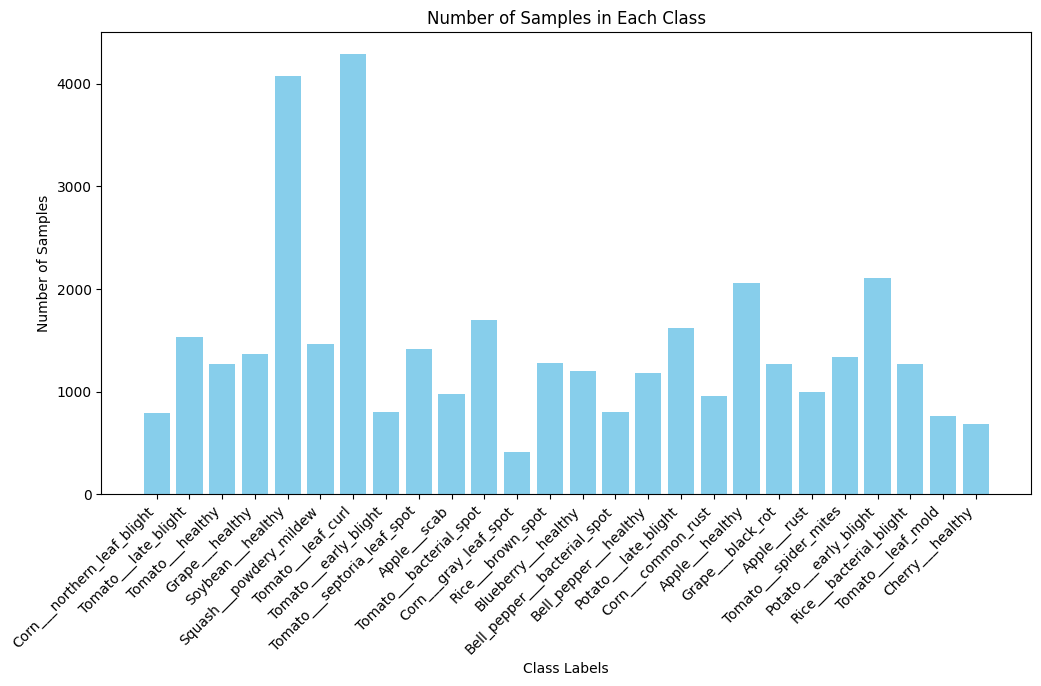

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(num_samples.keys(), num_samples.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [9]:
class_indices = test_ds.class_indices
samples_per_class = test_ds.classes
num_samples = {class_label: sum(samples_per_class == class_idx) for class_label, class_idx in class_indices.items()}
for class_label, num_sample in num_samples.items():
    print(f"{class_label}: {num_sample}")

Corn___northern_leaf_blight: 194
Tomato___late_blight: 111
Tomato___healthy: 52
Grape___healthy: 75
Soybean___healthy: 65
Squash___powdery_mildew: 130
Tomato___leaf_curl: 238
Tomato___early_blight: 88
Tomato___septoria_leaf_spot: 157
Apple___scab: 252
Tomato___bacterial_spot: 110
Corn___gray_leaf_spot: 67
Rice___brown_spot: 40
Blueberry___healthy: 117
Bell_pepper___bacterial_spot: 83
Bell_pepper___healthy: 42
Potato___late_blight: 208
Corn___common_rust: 117
Apple___healthy: 134
Grape___black_rot: 79
Apple___rust: 106
Tomato___spider_mites: 2
Potato___early_blight: 171
Rice___bacterial_blight: 40
Tomato___leaf_mold: 91
Cherry___healthy: 57


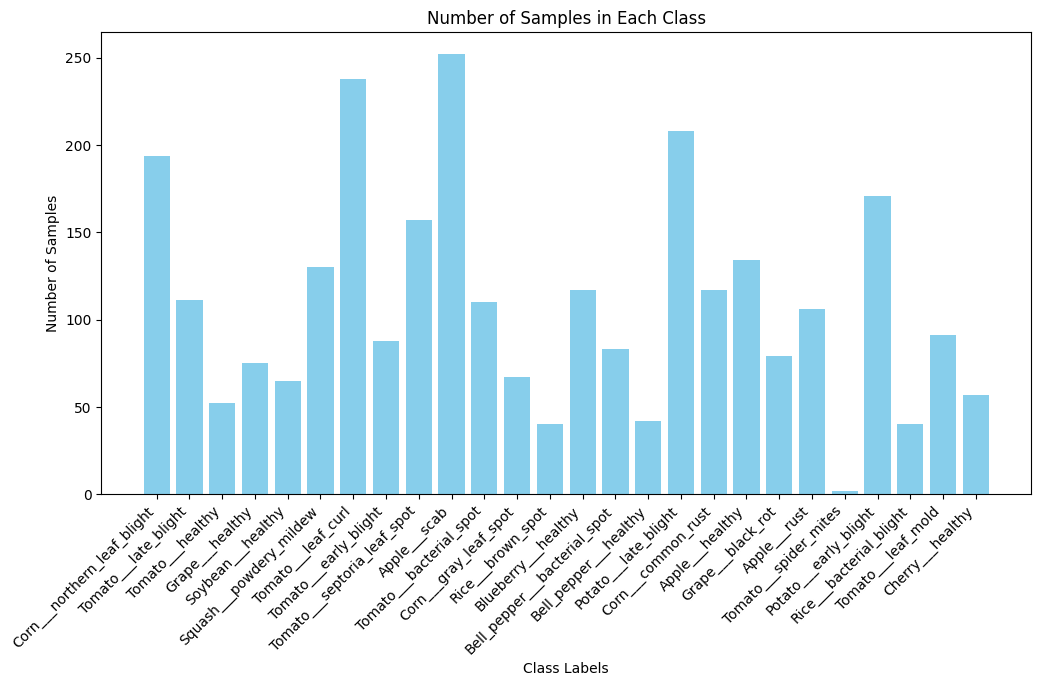

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(num_samples.keys(), num_samples.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [11]:
train_class_labels = list(train_ds.class_indices.keys())

num_classes = len(train_class_labels)
train_class_labels

['Corn___northern_leaf_blight',
 'Tomato___late_blight',
 'Tomato___healthy',
 'Grape___healthy',
 'Soybean___healthy',
 'Squash___powdery_mildew',
 'Tomato___leaf_curl',
 'Tomato___early_blight',
 'Tomato___septoria_leaf_spot',
 'Apple___scab',
 'Tomato___bacterial_spot',
 'Corn___gray_leaf_spot',
 'Rice___brown_spot',
 'Blueberry___healthy',
 'Bell_pepper___bacterial_spot',
 'Bell_pepper___healthy',
 'Potato___late_blight',
 'Corn___common_rust',
 'Apple___healthy',
 'Grape___black_rot',
 'Apple___rust',
 'Tomato___spider_mites',
 'Potato___early_blight',
 'Rice___bacterial_blight',
 'Tomato___leaf_mold',
 'Cherry___healthy']

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

In [15]:
from sklearn.utils.class_weight import compute_class_weight

true_labels = validation_ds.classes
class_indices = np.unique(true_labels)

class_weights = compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(true_labels), 
    y = true_labels)
class_weights = dict(enumerate(class_weights))

In [16]:
epochs = 20
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    callbacks=[early_stopping],
    class_weight=class_weights
)

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728040832.088326     119 service.cc:145] XLA service 0x7dd4ec003350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728040832.088387     119 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728040864.629520     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1728040864.682732     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the

1175/1175 ━━━━━━━━━━━━━━━━━━━━ 1188s 952ms/step - accuracy: 0.2872 - loss: 2.5007 - val_accuracy: 0.6056 - val_loss: 1.2616
Epoch 2/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 795s 673ms/step - accuracy: 0.7022 - loss: 0.9639 - val_accuracy: 0.7049 - val_loss: 0.9979
Epoch 3/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 784s 664ms/step - accuracy: 0.8367 - loss: 0.5483 - val_accuracy: 0.8475 - val_loss: 0.5026
Epoch 4/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 780s 661ms/step - accuracy: 0.8900 - loss: 0.3801 - val_accuracy: 0.7384 - val_loss: 0.8929
Epoch 5/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 780s 660ms/step - accuracy: 0.9140 - loss: 0.3010 - val_accuracy: 0.8556 - val_loss: 0.5417
Epoch 6/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 784s 664ms/step - accuracy: 0.9362 - loss: 0.2205 - val_accuracy: 0.9261 - val_loss: 0.2645
Epoch 7/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 785s 665ms/step - accuracy: 0.9471 - loss: 0.1860 - val_accuracy: 0.9419 - val_loss: 0.1980
Epoch 8/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 788s 668ms/step - accuracy: 0.

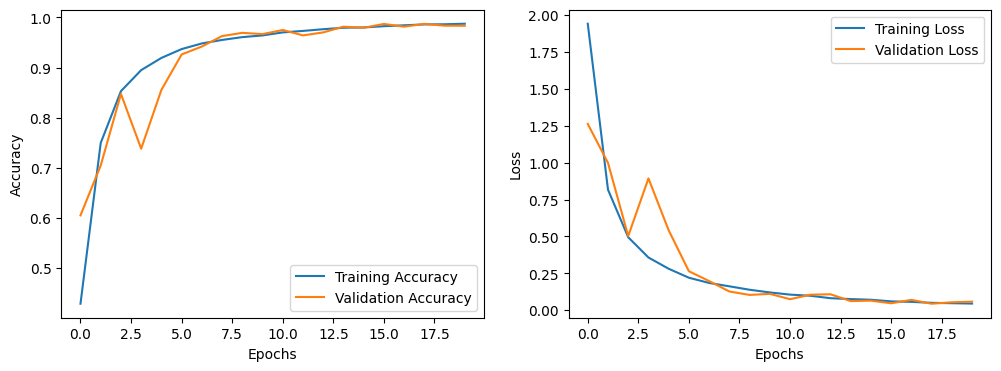

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
predictions = model.predict(validation_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = validation_ds.classes

print(classification_report(true_labels, predicted_labels, sample_weight=np.array([class_weights[i] for i in true_labels])))

294/294 ━━━━━━━━━━━━━━━━━━━━ 158s 526ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.93 361.0769230769239
           1       0.96      0.96      0.96 361.0769230769247
           2       1.00      1.00      1.00 361.07692307692497
           3       1.00      0.99      1.00 361.0769230769216
           4       0.98      1.00      0.99 361.07692307692014
           5       1.00      1.00      1.00 361.0769230769221
           6       0.99      1.00      0.99 361.0769230769281
           7       0.99      0.97      0.98 361.07692307692406
           8       0.99      0.98      0.99 361.0769230769238
           9       0.99      0.99      0.99 361.07692307692434
          10       0.95      0.98      0.97 361.07692307692355
          11       0.95      0.92      0.94 361.07692307692264
          12       1.00      1.00      1.00 361.07692307692434
          13       0.99      1.00      1.00 361.0769230769233
          14       0.99  

In [19]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = test_ds.classes

print(classification_report(true_labels, predicted_labels))

 2/89 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step  

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 350ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.06      0.72      0.11       111
           2       0.00      0.00      0.00        52
           3       0.17      0.01      0.02        75
           4       0.25      0.02      0.03        65
           5       0.00      0.00      0.00       130
           6       0.08      0.13      0.10       238
           7       0.00      0.00      0.00        88
           8       0.00      0.00      0.00       157
           9       0.00      0.00      0.00       252
          10       0.05      0.15      0.08       110
          11       0.26      0.09      0.13        67
          12       0.13      0.62      0.22        40
          13       0.10      0.12      0.11       117
          14       0.00      0.00      0.00        83
          15       0.00      0.00      0.00        42
          16       0.03      0.01      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


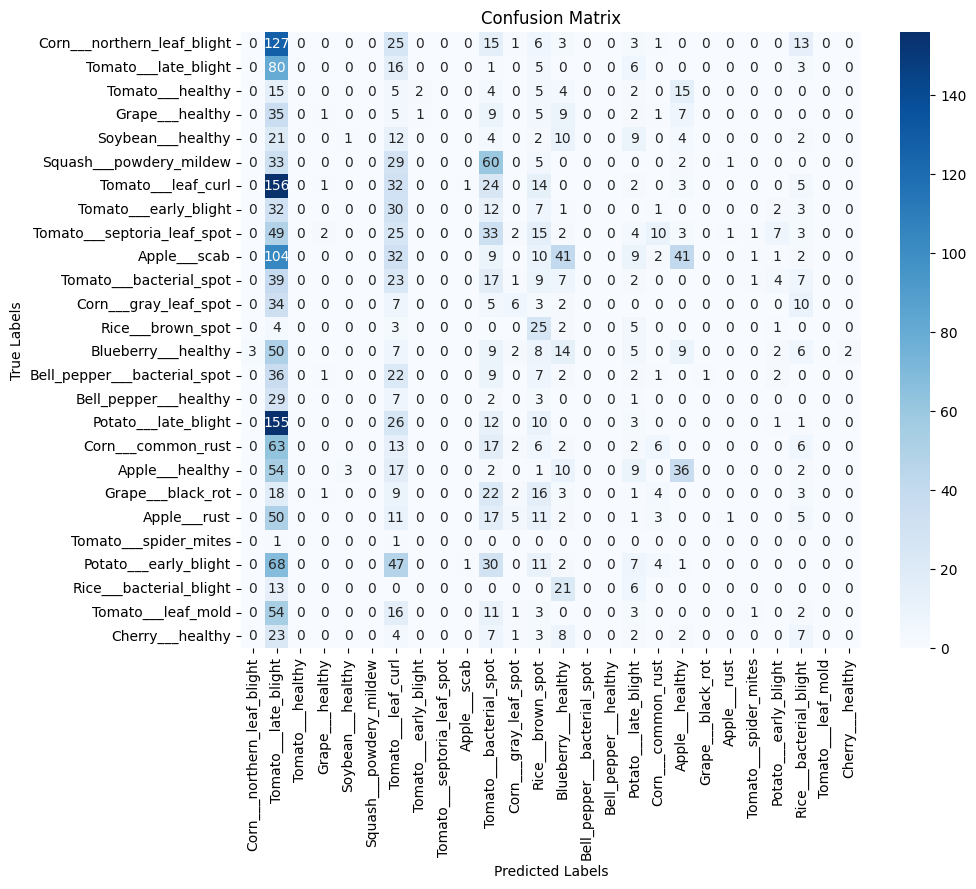

In [20]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=train_class_labels, yticklabels=train_class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [21]:
model.save("resnet.h5")